Comparison of weighted VAE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
import scipy
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from importlib import reload
import pandas as pd
import matplotlib
import matplotlib as mpl

In [2]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
import tools_for_VAE

from tools_for_VAE import vae_functions, model, plot, generator, results_processing, utils

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_vae_conv, denorm, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent
from tools_for_VAE.results_processing import VAE_processing


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Loading the trained VAE

In [49]:
vae_lsst_conv,vae_lsst_utils, encoder_LSST, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v16/mse/',6, folder= True) # v12/bis2

In [37]:
vae_lsst_weighted_conv,vae_lsst_weighted_utils, encoder_LSST_weighted, Dkl = load_vae_conv('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v_uni_2/bis_bis/mse/',6, folder = True)#v13/bis/ #v9/bis2

# Load data

In [5]:
data_dir = "/sps/lsst/users/barcelin/data/single_galaxies/28/test/"
root = 'galaxies_isolated_20191022_0'

In [6]:
images = np.load(data_dir+'galaxies_isolated_20191022_0_images.npy', mmap_mode = 'c')

In [7]:
test_sample = [data_dir+'galaxies_isolated_20191022_0_images.npy']

In [8]:
dfs = []

dfs.append(pd.read_csv(os.path.join(data_dir, root+'_data.csv')))
df = dfs[0]

for df2 in dfs[1:]:
    df = df.append(df2)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
redshift        10000 non-null float64
moment_sigma    10000 non-null float64
e1              10000 non-null float64
e2              10000 non-null float64
SNR             10000 non-null float64
SNR_peak        10000 non-null float64
mag             10000 non-null float64
dtypes: float64(7)
memory usage: 547.0 KB


# Parameters to fix

In [10]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

bands_r = [6]
bands_lsst = [4,5,6,7,8,9]
bands_lsst_euclid = [0,1,2,3,4,5,6,7,8,9]

## LSST all filters

In [33]:
reload(results_processing)

<module 'tools_for_VAE.results_processing' from '../../scripts/tools_for_VAE/tools_for_VAE/results_processing.py'>

In [11]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

In [50]:
N = 100
batch_size = 100

ellipticities_lsst, e_beta_lsst, flux_in_lsst, flux_out_lsst = results_processing.VAE_processing(vae_lsst_conv, 
                                                                                          test_sample[0],
                                                                                          bands_lsst,
                                                                                          2,
                                                                                          stamp_size, 
                                                                                          N, 
                                                                                          batch_size,
                                                                                          PSF, 
                                                                                          pix_scale_lsst)

In [51]:
errors_lsst = []

In [60]:
np.save('data/vae_lsst_e1_e2_20_w.npy', ellipticities_lsst) #_w naming to keep in mind it was done for comparison with weighted
np.save('data/vae_lsst_e_beta_20_w.npy', e_beta_lsst)
np.save('data/vae_lsst_flux_in_20_w.npy', flux_in_lsst)
np.save('data/vae_lsst_flux_out_20_w.npy', flux_out_lsst)
#np.save('data/vae_lsst_indices.npy', indices_lsst)

In [62]:
ellipticities_lsst = np.load('data/vae_lsst_e1_e2_2.npy')
e_beta_lsst = np.load('data/vae_lsst_e_beta_2.npy')
flux_in_lsst = np.load('data/vae_lsst_flux_in_2.npy')
flux_out_lsst = np.load('data/vae_lsst_flux_out_2.npy')
#indices_lsst = np.load('data/vae_lsst_indices.npy')

In [63]:
delta_e_lsst = np.sqrt(ellipticities_lsst[:,1,0]**2+ellipticities_lsst[:,1,1]**2)-np.sqrt(ellipticities_lsst[:,0,0]**2+ellipticities_lsst[:,0,1]**2)#e_beta_lsst[:,1,0]- e_beta_lsst[:,0,0]
delta_e1_lsst = ellipticities_lsst[:,1,0]- ellipticities_lsst[:,0,0]
delta_e2_lsst = ellipticities_lsst[:,1,1]- ellipticities_lsst[:,0,1]

In [64]:
delta_mag_lsst = -2.5*np.log10(flux_out_lsst/flux_in_lsst)

### Shape plots

In [65]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst[:,0,0]
df_plot['e1_out'] = ellipticities_lsst[:,1,0]

df_plot['e2_in'] = ellipticities_lsst[:,0,1]
df_plot['e2_out'] = ellipticities_lsst[:,1,1]

df_plot['e_in'] = e_beta_lsst[:,0,0]
df_plot['e_out'] = e_beta_lsst[:,1,0]

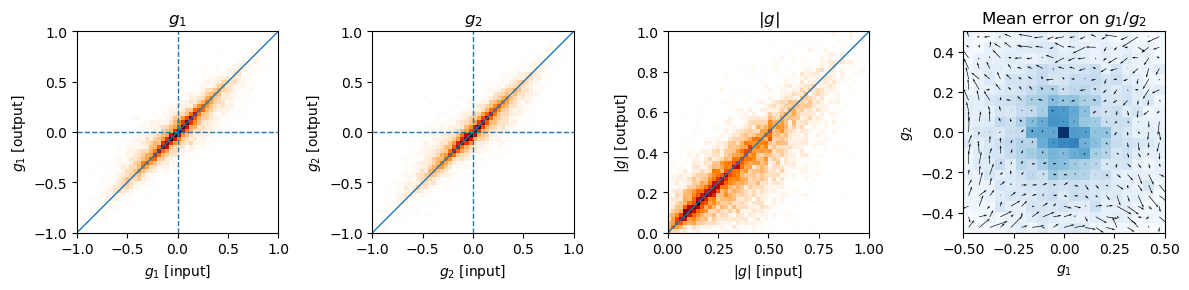

In [66]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()
#plt.savefig('figures/ellipticities_lsst.pdf', dpi = 300)

## LSST weighted

In [17]:
pix_scale_lsst = 0.2
PSF = galsim.Kolmogorov(fwhm=0.65)

In [38]:
N = 100#, indices_lsst_euclid
batch_size = 100

ellipticities_lsst_weighted, e_beta_lsst_weighted, flux_in_lsst_weighted, flux_out_lsst_weighted = results_processing.VAE_processing(vae_lsst_weighted_conv, 
                                                                                                                               test_sample[0],
                                                                                                                               bands_lsst,
                                                                                                                               2,
                                                                                                                               stamp_size, 
                                                                                                                               N, 
                                                                                                                               batch_size,
                                                                                                                               PSF, 
                                                                                                                               pix_scale_lsst)

In [39]:
errors_lsst_weighted = []

In [48]:
np.save('data/vae_lsst_weighted_e1_e2_2.npy', ellipticities_lsst_weighted)
np.save('data/vae_lsst_weighted_e_beta_2.npy', e_beta_lsst_weighted)
np.save('data/vae_lsst_weighted_flux_in_2.npy', flux_in_lsst_weighted)
np.save('data/vae_lsst_weighted_flux_out_2.npy', flux_out_lsst_weighted)
#np.save('data/vae_lsst_euclid_indices.npy', indices_lsst_euclid) # 2599, 4451 # 2935, 5557 # 61, 7955, 8216

In [24]:
ellipticities_lsst_weighted = np.load('data/vae_lsst_weighted_e1_e2_2.npy')
e_beta_lsst_weighted = np.load('data/vae_lsst_weighted_e_beta_2.npy')
flux_in_lsst_weighted = np.load('data/vae_lsst_weighted_flux_in_2.npy')
flux_out_lsst_weighted = np.load('data/vae_lsst_weighted_flux_out_2.npy')
#indices_lsst_euclid = np.load('data/vae_lsst_euclid_indices.npy')

In [40]:
delta_e_lsst_weighted = np.sqrt(ellipticities_lsst_weighted[:,1,0]**2+ellipticities_lsst_weighted[:,1,1]**2)-np.sqrt(ellipticities_lsst_weighted[:,0,0]**2+ellipticities_lsst_weighted[:,0,1]**2)#e_beta_lsst_weighted[:,1,0]- e_beta_lsst_weighted[:,0,0]
delta_e1_lsst_weighted = ellipticities_lsst_weighted[:,1,0]- ellipticities_lsst_weighted[:,0,0]
delta_e2_lsst_weighted = ellipticities_lsst_weighted[:,1,1]- ellipticities_lsst_weighted[:,0,1]

In [41]:
delta_mag_lsst_weighted = -2.5*np.log10(flux_out_lsst_weighted/flux_in_lsst_weighted)

In [240]:
print(delta_mag_lsst_weighted)

[ 0.02438364 -0.02283512  0.0657898  ...  0.05049783  0.13967887
 -0.01465674]


### Shape plots

In [42]:
df_plot = {}

df_plot['e1_in'] = ellipticities_lsst_weighted[:,0,0]
df_plot['e1_out'] = ellipticities_lsst_weighted[:,1,0]

df_plot['e2_in'] = ellipticities_lsst_weighted[:,0,1]
df_plot['e2_out'] = ellipticities_lsst_weighted[:,1,1]

df_plot['e_in'] = e_beta_lsst_weighted[:,0,0]
df_plot['e_out'] = e_beta_lsst_weighted[:,1,0]

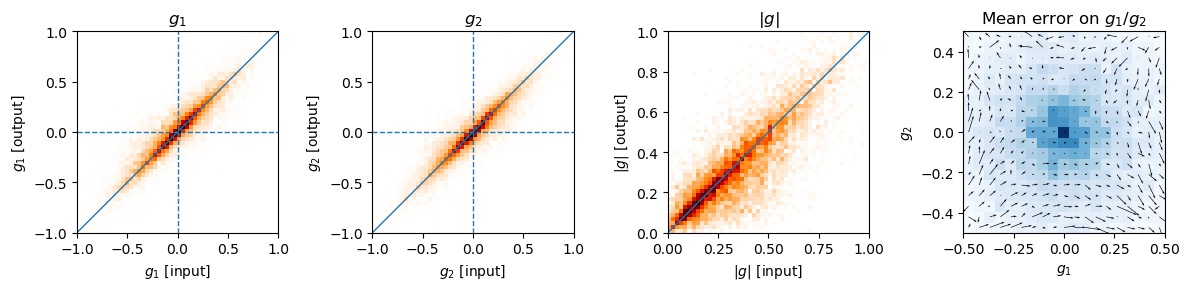

In [43]:
import scipy
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12,5))

# Cut in SNR
#df_plot = df[df['SNR_peak']>5.]

emax = 1
bins = np.linspace(-emax,+emax,51)

ax = fig.add_subplot(141, aspect='equal')
_ = ax.hist2d(df_plot['e1_in'], df_plot['e1_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_1$ [input]')
ax.set_ylabel('$g_1$ [output]')
ax.set_title('$g_1$')

ax = fig.add_subplot(142, aspect='equal')
_ = ax.hist2d(df_plot['e2_in'], df_plot['e2_out'], bins=bins, cmap=mpl.cm.gist_heat_r)
ax.plot([-emax,+emax],[-emax,+emax], lw=1)
ax.axhline(y=0, ls='--', lw=1)
ax.axvline(x=0, ls='--', lw=1)
ax.set_xlabel('$g_2$ [input]')
ax.set_ylabel('$g_2$ [output]')
ax.set_title('$g_2$')

ax = fig.add_subplot(143, aspect='equal')
_ = ax.hist2d(np.sqrt(df_plot['e1_in']**2+df_plot['e2_in']**2), np.sqrt(df_plot['e1_out']**2+df_plot['e2_out']**2), bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
#_ = ax.hist2d(df_plot['e_in'],df_plot['e_out'], bins=np.linspace(0,1,51), cmap=mpl.cm.gist_heat_r)
ax.plot([0,1],[0,1], lw=1)
ax.set_xlabel('$|g|$ [input]')
ax.set_ylabel('$|g|$ [output]')
ax.set_title('$|g|$')

emax = 0.5
ax = fig.add_subplot(144, aspect='equal')

bins = np.linspace(-emax,emax,20)
e1_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_in'], bins=bins, statistic='mean').statistic
e2_in_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_in'], bins=bins, statistic='mean').statistic
e1_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e1_out'], bins=bins, statistic='mean').statistic
e2_out_m = scipy.stats.binned_statistic_2d(df_plot['e1_in'], df_plot['e2_in'], values=df_plot['e2_out'], bins=bins, statistic='mean').statistic

im = ax.hist2d(df_plot['e1_in'], df_plot['e2_in'], bins=bins, cmap=mpl.cm.Blues)[-1]

bins_mid = 0.5*(bins[1:]+bins[:-1])
X,Y = np.meshgrid(bins_mid, bins_mid)
ax.quiver(X,Y,e1_out_m-e1_in_m, e2_out_m-e2_in_m)

ax.set_xlabel('$g_1$')
ax.set_ylabel('$g_2$')
ax.set_xlim(bins[0],bins[-1])
ax.set_ylim(bins[0],bins[-1])

ax.set_title('Mean error on $g_1/g_2$')

plt.tight_layout()

# Delta WL parameters

## As function of SNR

In [24]:
import itertools
from matplotlib.cbook import _reshape_2D
import matplotlib.pyplot as plt
import numpy as np

# Function adapted from matplotlib.cbook
def my_boxplot_stats(X, whis=1.5, bootstrap=None, labels=None,
                  autorange=False, percents=[25, 75]):

    def _bootstrap_median(data, N=5000):
        # determine 95% confidence intervals of the median
        M = len(data)
        percentiles = [2.5, 97.5]

        bs_index = np.random.randint(M, size=(N, M))
        bsData = data[bs_index]
        estimate = np.median(bsData, axis=1, overwrite_input=True)

        CI = np.percentile(estimate, percentiles)
        return CI

    def _compute_conf_interval(data, med, iqr, bootstrap):
        if bootstrap is not None:
            # Do a bootstrap estimate of notch locations.
            # get conf. intervals around median
            CI = _bootstrap_median(data, N=bootstrap)
            notch_min = CI[0]
            notch_max = CI[1]
        else:

            N = len(data)
            notch_min = med - 1.57 * iqr / np.sqrt(N)
            notch_max = med + 1.57 * iqr / np.sqrt(N)

        return notch_min, notch_max

    # output is a list of dicts
    bxpstats = []

    # convert X to a list of lists
    X = _reshape_2D(X, "X")

    ncols = len(X)
    if labels is None:
        labels = itertools.repeat(None)
    elif len(labels) != ncols:
        raise ValueError("Dimensions of labels and X must be compatible")

    input_whis = whis
    for ii, (x, label) in enumerate(zip(X, labels)):

        # empty dict
        stats = {}
        if label is not None:
            stats['label'] = label

        # restore whis to the input values in case it got changed in the loop
        whis = input_whis

        # note tricksyness, append up here and then mutate below
        bxpstats.append(stats)

        # if empty, bail
        if len(x) == 0:
            stats['fliers'] = np.array([])
            stats['mean'] = np.nan
            stats['med'] = np.nan
            stats['q1'] = np.nan
            stats['q3'] = np.nan
            stats['cilo'] = np.nan
            stats['cihi'] = np.nan
            stats['whislo'] = np.nan
            stats['whishi'] = np.nan
            stats['med'] = np.nan
            continue

        # up-convert to an array, just to be safe
        x = np.asarray(x)

        # arithmetic mean
        stats['mean'] = np.mean(x)

        # median
        med = np.percentile(x, 50)
        ## Altered line
        q1, q3 = np.percentile(x, (percents[0], percents[1]))

        # interquartile range
        stats['iqr'] = q3 - q1
        if stats['iqr'] == 0 and autorange:
            whis = 'range'

        # conf. interval around median
        stats['cilo'], stats['cihi'] = _compute_conf_interval(
            x, med, stats['iqr'], bootstrap
        )

        # lowest/highest non-outliers
        if np.isscalar(whis):
            if np.isreal(whis):
                loval = q1 - whis * stats['iqr']
                hival = q3 + whis * stats['iqr']
            elif whis in ['range', 'limit', 'limits', 'min/max']:
                loval = np.min(x)
                hival = np.max(x)
            else:
                raise ValueError('whis must be a float, valid string, or list '
                                 'of percentiles')
        else:
            loval = np.percentile(x, whis[0])
            hival = np.percentile(x, whis[1])

        # get high extreme
        wiskhi = np.compress(x <= hival, x)
        if len(wiskhi) == 0 or np.max(wiskhi) < q3:
            stats['whishi'] = q3
        else:
            stats['whishi'] = np.max(wiskhi)

        # get low extreme
        wisklo = np.compress(x >= loval, x)
        if len(wisklo) == 0 or np.min(wisklo) > q1:
            stats['whislo'] = q1
        else:
            stats['whislo'] = np.min(wisklo)

        # compute a single array of outliers
        stats['fliers'] = np.hstack([
            np.compress(x < stats['whislo'], x),
            np.compress(x > stats['whishi'], x)
        ])

        # add in the remaining stats
        stats['q1'], stats['med'], stats['q3'] = q1, med, q3

    return bxpstats

In [25]:
def boxplot(df,x, y, z,
            xlim, ylim, 
            x_scale, 
            legend,
            x_label, y_label,y_label_hist,
            errors = None,
            legend_remove = False,
            bias = False,
            palette = ["#3498db","#e74c3c"],
            nbins = 11):
    
    if bias == True:
        boxplot_bias(df,x, y, z,
            xlim, ylim, 
            x_scale, 
            legend,
            x_label, y_label,y_label_hist,
            errors = errors,
            legend_remove = legend_remove,
            palette = palette,
            nbins= nbins)
    else:
        median = []
        q1 = []
        q3 = []
        whislo = []
        whishi = []

        matplotlib.rcdefaults()

        if errors is not None:
            df_plot = df.drop(errors)
        else:
            df_plot = df
        df_plot = df_plot.dropna()

        if x_scale == 'log':
            x_bins = np.geomspace(xlim[0], xlim[1], nbins+1)
        else :
            x_bins = np.linspace(xlim[0], xlim[1], nbins+1)

        x_bins[0] -= 1e-5
        x_bins[-1] += 1e-5

        idx = np.digitize(df_plot[x], x_bins)    

        fig, axes = plt.subplots(2,1, figsize=(4,3), gridspec_kw={'height_ratios': [1, 3]})
        #fig.subplots_adjust(hspace=0,wspace=0.1) #right=1, left=0,
        #
        #fig.tight_layout()

        fig.subplots_adjust(hspace=0)

        if x_scale == 'log':
            sns.distplot(np.log10(df_plot[x]), ax=axes[0], color='0.8')
            axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
        else:
            sns.distplot(df_plot[x], ax=axes[0], color='0.8')
            axes[0].set_xlim(xlim[0], xlim[1])
        axes[0].set_xticks([])
        axes[0].set_yticks([])
        axes[0].set_ylabel(y_label_hist)

        ax = axes[1]
        #print(df_plot[z])
        exp = np.unique(df_plot[z])
        N_exp = len(exp)
        #print(exp)
        handles = []
        for ik, key in enumerate(exp):
            print(ik, key)
            stats = {}
            for i in range(1,len(x_bins)):
                stats[i] = my_boxplot_stats(df_plot[y][np.logical_and(idx==i,df_plot[z]==key)].values, whis=[100*scipy.stats.norm.cdf(-2),100*scipy.stats.norm.cdf(2)], percents=[100*scipy.stats.norm.cdf(-1),100*scipy.stats.norm.cdf(1)])[0]
                #print(stats[i])
                median.append(stats[i]['med'])
                q1.append(stats[i]['q1'])
                q3.append(stats[i]['q3'])
                whislo.append(stats[i]['whislo'])
                whishi.append(stats[i]['whishi'])
            # Plot boxplots from our computed statistics
            bp = ax.bxp([stats[i] for i in range(1,len(x_bins))],
                        positions=np.arange(len(x_bins)-1)+.5+0.3*(ik-(N_exp-1.)/2.),
                        widths=0.7/len(np.unique(df_plot[z])),
                        showfliers=False,
                        patch_artist=True,
                        boxprops={'facecolor':(*mpl.colors.to_rgba(palette[ik])[:3],0.25), 'edgecolor':palette[ik]})

            handles.append(bp['boxes'][0])

            # Colour the lines in the boxplot blue
            for element in bp.keys():
                if element != 'boxes':
                    plt.setp(bp[element], color=palette[ik])

        if not legend_remove:
            ax.legend(handles, legend, frameon=False, loc ='upper right', borderpad = 0.1, fontsize = 8)
        ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
        ax.set_xticks([])
        ax.set_xlim(0,len(x_bins)-1)
        ax.set_ylabel(y_label)
        ax.set_ylim(ylim[0],ylim[1])

        ax = ax.twiny()
        # ax2.set_yticks([])
        ax.set_xlim(xlim[0], xlim[1])
        if x_scale == 'log':
            ax.set_xscale('log')
        ax.xaxis.tick_bottom()
        ax.set_xlabel(x_label)
        ax.xaxis.set_label_position('bottom')


        fig.tight_layout()
        fig.subplots_adjust(hspace=0)
        return fig , median , q1, q3, whislo, whishi

In [26]:
def boxplot_bias(df,x, y, z,
            xlim, ylim, 
            x_scale, 
            legend,
            x_label, y_label,y_label_hist,
            errors = None,
            legend_remove = False,
            palette = ["#3498db","#e74c3c"],
            nbins = 11):
    
    median = []
    q1 = []
    q3 = []
    whislo = []
    whishi = []

    matplotlib.rcdefaults()

    if errors is not None:
        df_plot = df.drop(errors)
    else:
        df_plot = df
    df_plot = df_plot.dropna()

    if x_scale == 'log':
        x_bins = np.geomspace(xlim[0], xlim[1], nbins+1)
    else :
        x_bins = np.linspace(xlim[0], xlim[1], nbins+1)

    x_bins[0] -= 1e-5
    x_bins[-1] += 1e-5

    idx = np.digitize(df_plot[x], x_bins)    

    fig, axes = plt.subplots(3,1, figsize=(5,4), gridspec_kw={'height_ratios': [1, 3, 2]})
    #fig.subplots_adjust(hspace=0,wspace=0.1) #right=1, left=0,
    #
    #fig.tight_layout()

    fig.subplots_adjust(hspace=0)

    if x_scale == 'log':
        sns.distplot(np.log10(df_plot[x]), ax=axes[0], color='0.8')
        axes[0].set_xlim(np.log10(xlim[0]), np.log10(xlim[1]))
    else:
        sns.distplot(df_plot[x], ax=axes[0], color='0.8')
        axes[0].set_xlim(xlim[0], xlim[1])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_ylabel(y_label_hist)

    ax = axes[1]
    #print(df_plot[z])
    exp = np.unique(df_plot[z])
    N_exp = len(exp)
    #print(exp)
    handles = []
    for ik, key in enumerate(exp):
        print(ik, key)
        stats = {}
        for i in range(1,len(x_bins)):
            stats[i] = my_boxplot_stats(df_plot[y][np.logical_and(idx==i,df_plot[z]==key)].values, whis=[100*scipy.stats.norm.cdf(-2),100*scipy.stats.norm.cdf(2)], percents=[100*scipy.stats.norm.cdf(-1),100*scipy.stats.norm.cdf(1)])[0]
            #print(stats[i])
            median.append(stats[i]['med'])
            q1.append(stats[i]['q1'])
            q3.append(stats[i]['q3'])
            whislo.append(stats[i]['whislo'])
            whishi.append(stats[i]['whishi'])
        # Plot boxplots from our computed statistics
        bp = ax.bxp([stats[i] for i in range(1,len(x_bins))],
                    positions=np.arange(len(x_bins)-1)+.5+0.3*(ik-(N_exp-1.)/2.),
                    widths=0.7/len(np.unique(df_plot[z])),
                    showfliers=False,
                    patch_artist=True,
                    boxprops={'facecolor':(*mpl.colors.to_rgba(palette[ik])[:3],0.25), 'edgecolor':palette[ik]})

        handles.append(bp['boxes'][0])

        # Colour the lines in the boxplot blue
        for element in bp.keys():
            if element != 'boxes':
                plt.setp(bp[element], color=palette[ik])

    if not legend_remove:
        ax.legend(handles, legend, frameon=False, loc ='upper right', borderpad = 0.1, fontsize = 8)
    ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
    ax.set_xticks([])
    ax.set_xlim(0,len(x_bins)-1)
    ax.set_ylabel(y_label)
    ax.set_ylim(ylim[0],ylim[1])

    ax = ax.twiny()
    # ax2.set_yticks([])
    ax.set_xlim(xlim[0], xlim[1])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.set_xticks([])
    

    d_new = pd.DataFrame()
    d_new['e'] = np.concatenate(((np.arange(len(x_bins)-1)+.5)/(len(x_bins)-1), (np.arange(len(x_bins)-1)+.5)/(len(x_bins)-1)))#+df_plot[x]
    #print(d_new['e'])
    #print(len(median), len(d_new['e']))
    d_new['median'] = median
    d_new['exp'] = [legend[0]]*len(np.arange(len(x_bins)-1)+.5)+[legend[1]]*len(np.arange(len(x_bins)-1)+.5)
    #print(len(d_new['exp']), len(d_new['bias']), len(d_new['e']))
    #print(d_new['exp'])
    ax = axes[2]
    sns.lineplot(x = 'e', y = 'median', hue = 'exp',data = d_new, ax = axes[2], palette= ["#3498db","#e74c3c"])
    if x_scale == 'log':
        ax.set_xscale('log')
    ax.set_xlabel(x_label)
    ax.set_ylim(ylim[0]/10,ylim[1]/10)
    ax.xaxis.tick_bottom()
    ax.xaxis.set_label_position('bottom')
    ax.axhline(y=0, c='0.5', zorder=32, lw=0.5)
    ax.set_xlim(xlim[0], xlim[1])
    
    if not legend_remove:
        ax.legend(legend, frameon=False, loc ='upper right', borderpad = 0.1, fontsize = 8)
    else:
        ax.get_legend().remove()
    fig.tight_layout()
    fig.subplots_adjust(hspace=0)
    return fig , median , q1, q3, whislo, whishi

In [67]:
errors_lsst_weighted_new = []

if errors_lsst != []:
    for i in range (len(errors_lsst_weighted)):
        errors_lsst_weighted_new.append(errors_lsst_weighted[i] + 10000)
else:
    errors_lsst_weighted_new= errors_lsst_weighted
    
errors =  errors_lsst+ errors_lsst_weighted_new


frames = [df,df]
df_plot = pd.concat(frames, ignore_index=True)

if errors is not None:
    df_plot = df_plot.drop(errors)
else:
    df_plot = df_plot

df_plot['e_error'] = np.concatenate((delta_e_lsst, delta_e_lsst_weighted[:10000]))
df_plot['mag_error'] = np.concatenate((delta_mag_lsst, delta_mag_lsst_weighted[:10000]))
df_plot['exp'] = [1]*(len(df)-len(errors_lsst)) + [2]*(len(df)-len(errors_lsst_weighted[:10000]))
df_plot['e'] = np.sqrt(df_plot['e1']**2+df_plot['e2']**2)
df_plot['e_meas'] = np.concatenate((e_beta_lsst[:,0,0], e_beta_lsst_weighted[:10000,0,0]))

0 1
1 2


TypeError: 'NoneType' object is not iterable

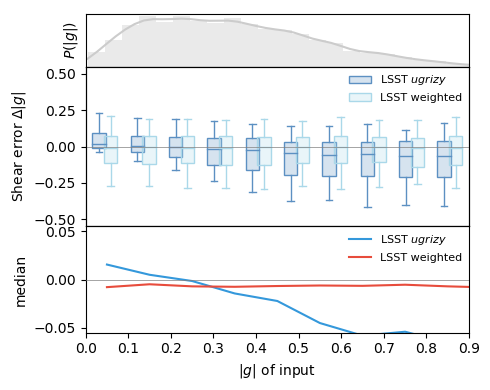

In [68]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e', y = 'e_error', z = 'exp',
              xlim = (0., .9),
              ylim = (-0.55, 0.55), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$|g|$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(|g|)$',
              legend_remove = False,
              bias = True,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

In [57]:
errors_lsst_weighted_new = []

if errors_lsst != []:
    for i in range (len(errors_lsst_weighted)):
        errors_lsst_weighted_new.append(errors_lsst_weighted[i] + 10000)
else:
    errors_lsst_weighted_new= errors_lsst_weighted
    
errors =  errors_lsst+ errors_lsst_weighted_new


frames = [df,df,df,df,df,df,df,df]
df_plot = pd.concat(frames, ignore_index=True)

if errors is not None:
    df_plot = df_plot.drop(errors)
else:
    df_plot = df_plot

df_plot['e_error'] = np.concatenate((delta_e_lsst, delta_e_lsst_weighted))
df_plot['mag_error'] = np.concatenate((delta_mag_lsst, delta_mag_lsst_weighted))
df_plot['exp'] = [1]*(len(df)*4-len(errors_lsst)) + [2]*(len(df)*4-len(errors_lsst_weighted))
df_plot['e'] = np.sqrt(df_plot['e1']**2+df_plot['e2']**2)
df_plot['e_meas'] = np.concatenate((e_beta_lsst[:,0,0], e_beta_lsst_weighted[:,0,0]))

0 1
1 2


TypeError: 'NoneType' object is not iterable

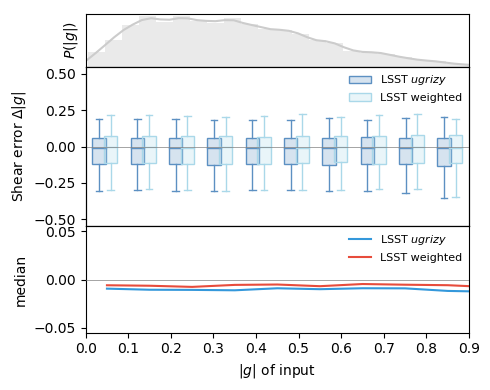

In [59]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e', y = 'e_error', z = 'exp',
              xlim = (0., .9),
              ylim = (-0.55, 0.55), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$|g|$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(|g|)$',
              legend_remove = False,
              bias = True,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

In [ ]:
np.min(df['SNR_peak'])

0 1
1 2


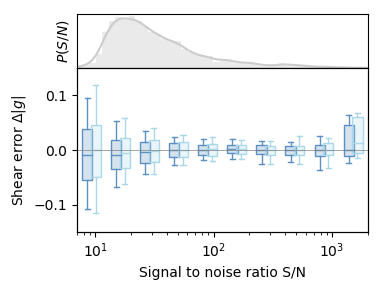

In [221]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'SNR_peak', y = 'e_error', z = 'exp',
              xlim = (7, 2000),
              ylim = (-0.15, 0.15), 
              x_scale = 'log',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='Signal to noise ratio S/N', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(S/N)$',
              legend_remove = True,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

#fig.savefig('figures/e_snr.pdf')

In [49]:
np.where(np.isnan(df_plot['e1']))[0]

array([], dtype=int64)

0 1
1 2


TypeError: 'NoneType' object is not iterable

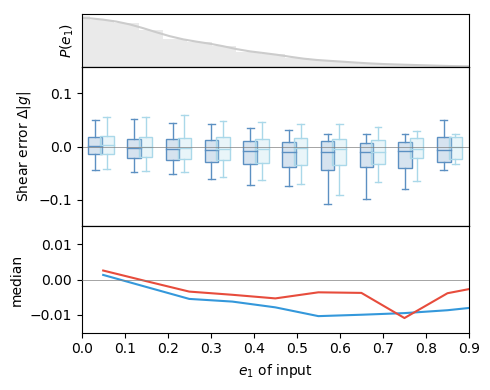

In [226]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e1', y = 'e_error', z = 'exp',
              xlim = (0., .9),
              ylim = (-0.15, 0.15), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$e_1$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(e_1)$',
              legend_remove = True,
              bias = True,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)


0 1
1 2


TypeError: 'NoneType' object is not iterable

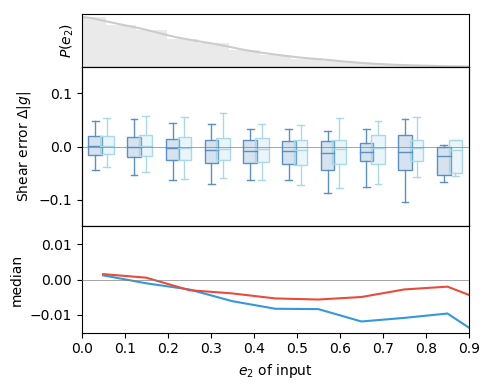

In [227]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e2', y = 'e_error', z = 'exp',
              xlim = (0., .9),
              ylim = (-0.15, 0.15), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$e_2$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(e_2)$',
              legend_remove = True,
              bias = True,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

0 1
1 2


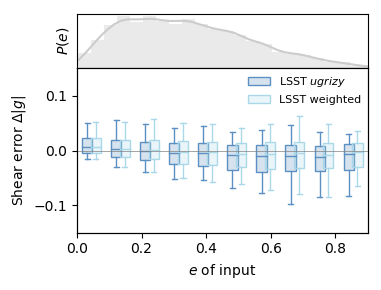

In [59]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e', y = 'e_error', z = 'exp',
              xlim = (0., .9),
              ylim = (-0.15, 0.15), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$e$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(e)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

0 1
1 2


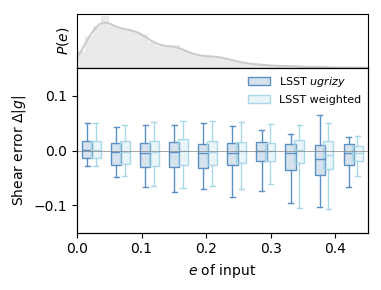

In [64]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = boxplot(df_plot, 
              x = 'e_meas', y = 'e_error', z = 'exp',
              xlim = (0., .45),
              ylim = (-0.15, 0.15), 
              x_scale = 'linear',
              legend = ['LSST $ugrizy$', 'LSST weighted'],
              x_label='$e$ of input', 
              y_label = 'Shear error $\\Delta |g|$',
              y_label_hist='$P(e)$',
              legend_remove = False,
              palette=mpl.cm.RdYlBu([0.85,0.7]),
              nbins = 10)

In [216]:
df_stat = pd.DataFrame()
df_stat['median_shear'] = median_shear
df_stat['q1_shear'] = q1_shear
df_stat['q3_shear'] = q3_shear
df_stat['whislo_shear'] = whislo_shear
df_stat['whishi_shear'] = whishi_shear
df_stat['median_mag'] = median_mag
df_stat['q1_mag'] = q1_mag
df_stat['q3_mag'] = q3_mag
df_stat['whislo_mag'] = whislo_mag
df_stat['whishi_mag'] = whishi_mag
df_stat['stats_names'] = ['r band']*10 + ['LSST']*10 + ['LSST Euclid']*10

In [252]:
param = 'median_shear'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.02413317869817999, -0.0016494843527162608, 0.0006241145377040465]
improvement between each exp: [14.630741212209186, -2.6429192929622833]


In [253]:
param = 'q1_shear'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.09631697113482418, -0.01793763037121116, -0.007426839101955372]
improvement between each exp: [5.3695482146519895, 2.4152442411857904]


In [255]:
param = 'q3_shear'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.0276941325052417, 0.017787613639560336, 0.01027267081341637]
improvement between each exp: [1.5569335531129866, 1.7315471275813938]


In [256]:
param = 'whislo_shear'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.20943353644242663, -0.039011109413730316, -0.021791001180049382]
improvement between each exp: [5.36856140699025, 1.790239424586269]


In [257]:
param = 'whishi_shear'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [0.08853536932546865, 0.036984036421479315, 0.021123520166362854]
improvement between each exp: [2.3938806547910962, 1.7508462666356523]


In [258]:
param = 'median_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.005875948746374172, 0.024837896282496594, 0.011948886416220005]
improvement between each exp: [-0.23657191734531022, 2.0786787502457478]


In [251]:
param = 'q1_mag'
x = 10 # for the first x bins
print('mean for each exp: '+str([np.mean(df_stat[param][:x]), np.mean(df_stat[param][10:10+x]), np.mean(df_stat[param][20:20+x])]))
print('improvement between each exp: '+str([np.mean(df_stat[param][:x])/np.mean(df_stat[param][10:10+x]) , np.mean(df_stat[param][10:10+x])/np.mean(df_stat[param][20:20+x])]))

mean for each exp: [-0.08181082392928671, -0.03570730136353202, -0.03931890248070341]
improvement between each exp: [2.291151131707768, 0.908145932635229]
